In [77]:
import pandas as pd
import numpy as np
from math import pi,sqrt,log
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,load_diabetes,make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score,confusion_matrix
import timeit

time: 0 ns (started: 2023-02-05 23:22:35 -05:00)


In [78]:
!pip install ipython-autotime
%load_ext autotime

  %reload_ext autotime
time: 1.17 s (started: 2023-02-05 23:22:36 -05:00)


You should consider upgrading via the 'C:\Users\siruv\PycharmProjects\MachineLearning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [79]:
def gen_hyperplanes(n,m,HIGH=1,LOW=-1):#n dimensions m planes
  planes=[]
  for x in range(m):
    temp=(np.tan(np.random.rand(n)*pi))
    temp=np.array((*(np.random.rand(1)*(HIGH-LOW)+LOW),*temp))
    planes.append(temp)
  return planes
def gen_func(coeffs):
  def f(point):
    return (coeffs[0]+(sum(coeffs[i]*point[i-1] for i in range(1,len(coeffs)))))>0
  return f
def test_hyperplanes(point,hyperplanes):#assigns point a region number
    v=0
    for hyperplane in hyperplanes:
      v+=hyperplane(point)
      v<<=1
    return v>>1
def generate_planes(df):
  n=len(df.columns)-1
  m=int(log(len(df))+.5)
  all_coeffs=gen_hyperplanes(n,m)
  return tuple(gen_func(coeff) for coeff in all_coeffs)
def assign_planes(df,hyperplanes):
  return df.drop('id',axis=1).apply(test_hyperplanes,hyperplanes=hyperplanes,axis=1)

time: 0 ns (started: 2023-02-05 23:22:37 -05:00)


In [92]:
train=pd.read_csv("Data/train_chem.csv").drop("Unnamed: 0", axis=1)
test=pd.read_csv("Data/test_chem.csv").drop("Unnamed: 0",axis=1)
for c in train.drop('id',axis=1).columns:#ignore id
  train[c]=(train[c]-train[c].mean())/train[c].std()
for c in test.drop('id',axis=1).columns:#ignore id
  test[c]=(test[c]-test[c].mean())/test[c].std()

time: 1.73 s (started: 2023-02-05 23:41:38 -05:00)


In [80]:
train=pd.read_csv("Data/newDF_chem.csv").drop("Unnamed: 0",axis=1)
test=pd.read_csv("Data/test_chem.csv").drop("Unnamed: 0",axis=1)
for c in train.drop('id',axis=1).columns:#ignore id
  train[c]=(train[c]-train[c].mean())/train[c].std()
for c in test.drop('id',axis=1).columns:#ignore id
  test[c]=(test[c]-test[c].mean())/test[c].std()

time: 1 s (started: 2023-02-05 23:22:40 -05:00)


In [81]:
#dont run for baseline testing
planes=generate_planes(train)
train['region']=assign_planes(train,planes)
test['region']=assign_planes(test,planes)

time: 1min 43s (started: 2023-02-05 23:22:42 -05:00)


In [53]:
#only for baseline testing
train['region']=None
overall_knn=KNeighborsClassifier(n_neighbors=5,algorithm="ball_tree").fit(train.drop('id',axis=1).drop('region',axis=1),train['id'])

time: 484 ms (started: 2023-02-05 23:04:05 -05:00)


In [54]:
base_pred=overall_knn.predict(test.drop('id',axis=1))

time: 3min 42s (started: 2023-02-05 23:04:08 -05:00)


In [55]:
truth=test['id']
accuracy=accuracy_score(truth,base_pred)
balanced_accuracy=balanced_accuracy_score(truth,base_pred)
accuracy,balanced_accuracy

(0.9802096900935424, 0.9808246276874363)

time: 875 ms (started: 2023-02-05 23:08:31 -05:00)


Text(0.5, 1.0, 'ball_tree KNN w/ RMHC')

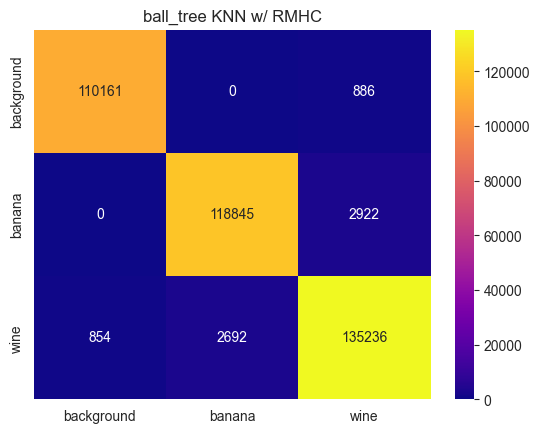

time: 1.09 s (started: 2023-02-05 23:08:56 -05:00)


In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay,balanced_accuracy_score
import matplotlib.pyplot as plt

pred=base_pred

labels='background','banana','wine'
plot=sns.heatmap((confusion_matrix((truth),(pred))),cmap="plasma",annot=True,fmt="")
plot.set_xticklabels(labels)
plot.set_yticklabels(labels)
plot.set_title("ball_tree KNN w/ RMHC")

In [82]:
regional_knns={region:
               lambda x:pd.Series(index=x.index,data=train[train['region']==region]['id'].value_counts().index[0])
               if len(train[train['region']==region])<5
               else KNeighborsClassifier(n_neighbors=5,algorithm="brute").fit(train[train['region']==region].drop('id',axis=1),train[train['region']==region]['id']).predict for region in train['region'].unique()}
overall_knn=KNeighborsClassifier(n_neighbors=5,algorithm="brute").fit(train.drop('id',axis=1).drop('region',axis=1),train['id'])
test['ISIN']=test['region'].apply(lambda r:r in regional_knns)
test_x,test_y=test.drop('id',axis=1),test[['id','ISIN','region']]
test['ISIN'].value_counts()

True     371479
False       117
Name: ISIN, dtype: int64

time: 250 ms (started: 2023-02-05 23:25:11 -05:00)


In [83]:
test_x,test_y=test.drop('id',axis=1),test[['id','ISIN','region']]
t=test_x[test_x['ISIN']==True]
out=test_x[test_x['ISIN']==False]
knn=KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree').fit(train.drop(['id','region'],axis=1),train['id'])
overall_pred=pd.Series(index = out.index,data = knn.predict(out.drop(['region','ISIN'],axis=1)))
region_pred = []
for region in t['region'].unique():
  cur_test=t[t['region']==region]
  cur_train=train[train['region']==region]
  if len(train[train['region']==region])<5:
    region_pred.append( pd.Series(index=cur_test.index,data=cur_train['id'].value_counts().index[0]) )
  else:
    knn=KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree').fit(cur_train.drop(['id','region'],axis=1),cur_train['id'])
    region_pred.append(pd.Series(index=cur_test.index,data=knn.predict(cur_test.drop(['region','ISIN'],axis=1))))
truth=test_y['id']
pred=pd.concat([*region_pred,overall_pred])

time: 7.52 s (started: 2023-02-05 23:25:12 -05:00)


In [85]:
accuracy=accuracy_score(truth,pred.sort_index())
print(accuracy)

0.9790982680114964
time: 250 ms (started: 2023-02-05 23:26:16 -05:00)


Text(0.5, 1.0, 'ball_tree KNN w/ Hyperplane Division and RMHC')

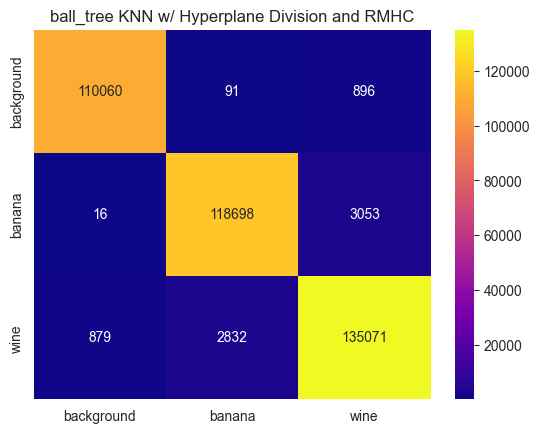

time: 1.16 s (started: 2023-02-05 23:25:32 -05:00)


In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay,balanced_accuracy_score
import matplotlib.pyplot as plt

pred=pred.sort_index()

labels='background','banana','wine'
plot=sns.heatmap((confusion_matrix((truth),(pred))),cmap="plasma",annot=True,fmt="")
plot.set_xticklabels(labels)
plot.set_yticklabels(labels)
plot.set_title("ball_tree KNN w/ Hyperplane Division and RMHC")

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour
train['region']=None
cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(train.drop('id',axis=1).drop('region',axis=1),train['id'])

In [ ]:
overall_knn=KNeighborsClassifier(n_neighbors=5,algorithm="brute").fit(X_res,y_res)
base_pred=overall_knn.predict(test.drop('id',axis=1))

In [ ]:
truth=test['id']
accuracy=accuracy_score(truth,base_pred)
balanced_accuracy=balanced_accuracy_score(truth,base_pred)
accuracy,balanced_accuracy